In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image
from numpy import array
from scipy.stats import t, sem, ttest_rel

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/home/ben/Data/empo_3/'

In [5]:
er = read_csv(join(empo3_dir, 'eval_taxa_er.tsv'), sep='\t')

In [6]:
len(set(er['sample']))

21513

In [7]:
grouped = er.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    errors = x['errors'].sum()
    abundance = x['reads'].sum()
    return Series([errors/abundance], index=['mean'])
figure4 = grouped.apply(weighted_stats)
figure4.reset_index(inplace=True)
old_labels = [
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure4.loc[figure4['class weights'] == old, 'class weights'] = new
figure4['class class'] = figure4['class weights']
figure4.loc[(figure4['class weights'] != 'Average') &
            (figure4['class weights'] != 'Uniform') &
            (figure4['class weights'] != 'Bespoke'),
            'class class'] = 'Other'
figure4 = figure4[figure4['class class'] != 'Other']
old_levels = range(1,8)
new_levels = ('Kingdom',
             'Phylum',
             'Class',
             'Order',
             'Family',
             'Genus',
             'Species')
for old, new in zip(old_levels, new_levels):
    figure4.loc[figure4['level'] == old, 'level'] = new

In [8]:
figure4

,sample type,class weights,level,mean,class class
28,animal-corpus,Average,Kingdom,7.586883e-06,Average
29,animal-corpus,Average,Phylum,1.212510e-02,Average
30,animal-corpus,Average,Class,1.791395e-02,Average
31,animal-corpus,Average,Order,4.785558e-02,Average
32,animal-corpus,Average,Family,7.045442e-02,Average
33,animal-corpus,Average,Genus,1.670921e-01,Average
34,animal-corpus,Average,Species,2.077546e-01,Average
35,animal-corpus,Bespoke,Kingdom,7.637462e-06,Bespoke
36,animal-corpus,Bespoke,Phylum,1.129348e-02,Bespoke
37,animal-corpus,Bespoke,Class,1.601136e-02,Bespoke


In [9]:
%%R -i figure4

figure4$class.weights = factor(figure4$class.weights, levels=c(
    'Bespoke', 'Average', 'Uniform'
))
figure4$level = factor(figure4$level, c('Kingdom',
                 'Phylum',
                 'Class',
                 'Order',
                 'Family',
                 'Genus',
                 'Species'))

cbPalette <- c("#009E73", "#56B4E9", "#E69F00")
ggplot(figure4, aes(x=level, y=mean*100, fill=class.weights)) + 
geom_boxplot(lwd=0.2, outlier.size=0.2, position=position_dodge(width=0.9)) +
theme_bw() +
  labs(y='Error Rate (%)', x='Taxonomy Level') +
  scale_colour_manual(name='Taxonomic Weights', values=cbPalette) +
  scale_fill_manual(name='Taxonomic Weights', values=cbPalette) +
theme(axis.text.x = element_text(angle = 30, vjust=1, hjust=1))

ggsave(file="3d-plot.png", width=5, height=5, dpi=300)

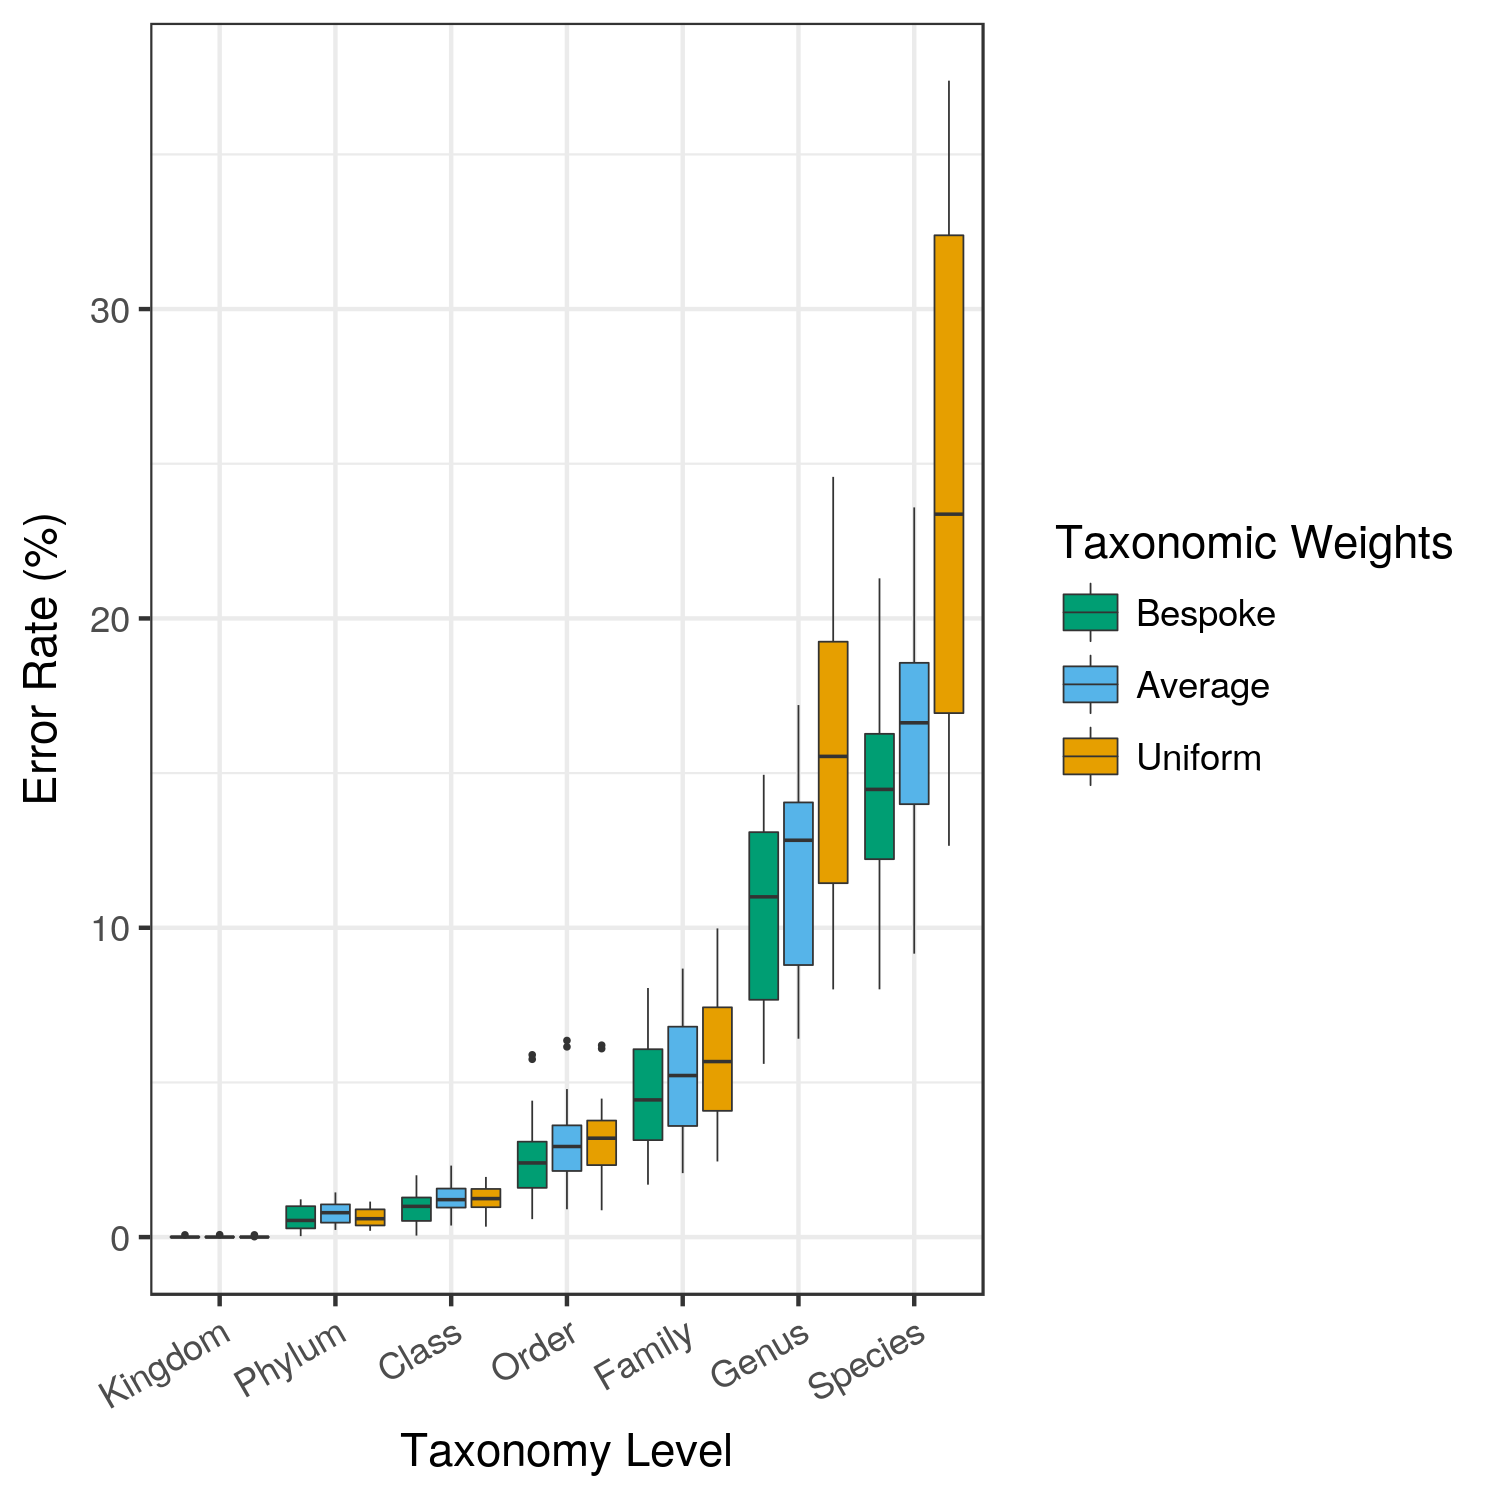

In [10]:
Image("3d-plot.png")

In [11]:
grouped = figure4.groupby(['class weights', 'level'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(weighted_stats)
figure4.reset_index(inplace=True)

In [14]:
figure4

,sample type,class weights,level,mean,class class
28,animal-corpus,Average,Kingdom,7.586883e-06,Average
29,animal-corpus,Average,Phylum,1.212510e-02,Average
30,animal-corpus,Average,Class,1.791395e-02,Average
31,animal-corpus,Average,Order,4.785558e-02,Average
32,animal-corpus,Average,Family,7.045442e-02,Average
33,animal-corpus,Average,Genus,1.670921e-01,Average
34,animal-corpus,Average,Species,2.077546e-01,Average
35,animal-corpus,Bespoke,Kingdom,7.637462e-06,Bespoke
36,animal-corpus,Bespoke,Phylum,1.129348e-02,Bespoke
37,animal-corpus,Bespoke,Class,1.601136e-02,Bespoke


In [11]:
uniform = figure4[figure4['class weights'] == 'Uniform']
print(uniform[uniform['level'] == 'Class']['mean'].mean())
print(sem(uniform[uniform['level'] == 'Class']['mean']))
print(uniform[uniform['level'] == 'Genus']['mean'].mean())
print(sem(uniform[uniform['level'] == 'Genus']['mean']))
print(uniform[uniform['level'] == 'Species']['mean'].mean())
print(sem(uniform[uniform['level'] == 'Species']['mean']))

0.011729577771861998
0.0013139490387997675
0.15670984905581337
0.012778561880711617
0.24522937990853752
0.02296942781082988


In [12]:
ttest_rel(array(uniform[uniform['level'] == 'Genus']['mean']) - uniform[uniform['level'] == 'Class']['mean'],
          array(uniform[uniform['level'] == 'Species']['mean']) - uniform[uniform['level'] == 'Genus']['mean'])

Ttest_relResult(statistic=1.8801225279779694, pvalue=0.08268512379463609)

In [13]:
(array(array(uniform[uniform['level'] == 'Genus']['mean']) - uniform[uniform['level'] == 'Order']['mean']) -
          (array(uniform[uniform['level'] == 'Species']['mean']) - uniform[uniform['level'] == 'Genus']['mean'])).mean()

0.03654663396474787

In [15]:
bespoke = figure4[figure4['class weights'] == 'Bespoke']
ttest_rel(array(uniform[uniform['level'] == 'Species']['mean']),
          array(bespoke[bespoke['level'] == 'Species']['mean']))

Ttest_relResult(statistic=5.911685034439124, pvalue=5.1366104038382295e-05)

In [17]:
print(bespoke[bespoke['level'] == 'Class']['mean'].mean())
print(sem(bespoke[bespoke['level'] == 'Class']['mean']))
print(bespoke[bespoke['level'] == 'Genus']['mean'].mean())
print(sem(bespoke[bespoke['level'] == 'Genus']['mean']))
print(bespoke[bespoke['level'] == 'Species']['mean'].mean())
print(sem(bespoke[bespoke['level'] == 'Species']['mean']))

0.009927308771314933
0.0016213506051542498
0.10430293849193985
0.008632762305920257
0.14316299916085123
0.009221863378321031
